<a href="https://colab.research.google.com/github/cabb1808/ProyectoSenales3/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy as sp


In [ ]:
!wget 'https://raw.githubusercontent.com/cabb1808/ProyectoSenales3/main/TRM.csv' -O 'TRM.csv'

--2023-06-03 18:49:11--  https://raw.githubusercontent.com/cabb1808/ProyectoSenales3/main/TRM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220043 (215K) [text/plain]
Saving to: ‘TRM.csv’

TRM.csv             100%[===================>] 214.89K  --.-KB/s    in 0.03s   

2023-06-03 18:49:11 (7.48 MB/s) - ‘TRM.csv’ saved [220043/220043]



In [ ]:
#Importamos la database y ordenamos en orden cronologico ya que no lo está

data = pd.read_csv('TRM.csv')
# Convertir la columna de fechas al formato de fecha adecuado
data['VIGENCIADESDE'] = pd.to_datetime(data['VIGENCIADESDE'], format='%d/%m/%Y')

# Ordenar los datos por fecha
data.sort_values(by='VIGENCIADESDE', inplace=True)
datos = data[['VIGENCIADESDE', 'VALOR']]

print(datos)

     VIGENCIADESDE    VALOR
376     1991-12-02   643.42
377     1991-12-03   639.22
378     1991-12-04   635.70
6187    1991-12-05   631.51
6188    1991-12-06   627.16
...            ...      ...
7363    2022-07-14  4558.05
7364    2022-07-15  4519.65
7365    2022-07-16  4395.63
7366    2022-07-19  4315.41
7367    2022-07-20  4303.34

[7368 rows x 2 columns]


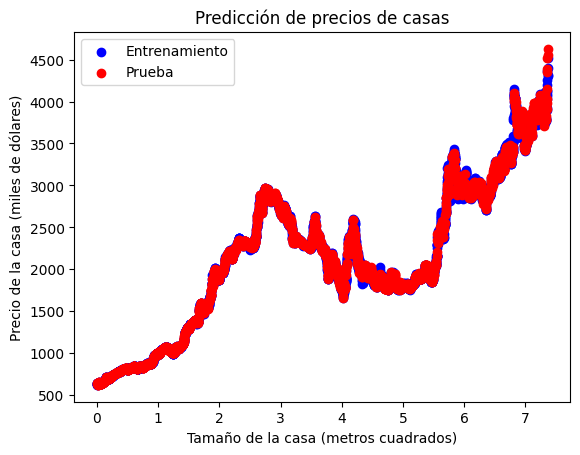

In [ ]:
#Creamos un vector temporal y separamos los datos en train y test


x = np.arange(0, 7368/1000, 0.001)
X_train, X_test, y_train, y_test = train_test_split(x, datos['VALOR'], test_size=0.3, random_state=42)
X_train=X_train.reshape(-1, 1)
X_test=X_test.reshape(-1, 1)

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.xlabel('Tamaño de la casa (metros cuadrados)')
plt.ylabel('Precio de la casa (miles de dólares)')
plt.title('Predicción de precios de casas')
plt.legend()


In [ ]:
def expo_carac(X, K):
    # Extraer caracteristicas exponenciales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,10,K)
    sig2 = 0.1

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:,k] = np.exp(-(mu[k-1] - X)**2/sig2) 
    return Phi

def cos_carac(X, K):
    # Extraer caracteristicas sinusoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    F0= 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
      if k%2 ==0:
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X) 
      else:
        Phi[:,k] = np.sin(2*np.pi*F[k-1]*X)
    return Phi


def sigmo_carac(X, K):

    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,10,K)
    # Calcular matriz Phi
    for k in range(1,K+1):
      Phi[:,k] = 1/(1 + np.exp(-X + mu[k-1])) 
    return Phi

In [ ]:
def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados 
    
    kappa = 1e-09 # jitter
    D = Phi.shape[1]  
    
    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y 
    return theta_ml

In [ ]:
# Aplicar PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)

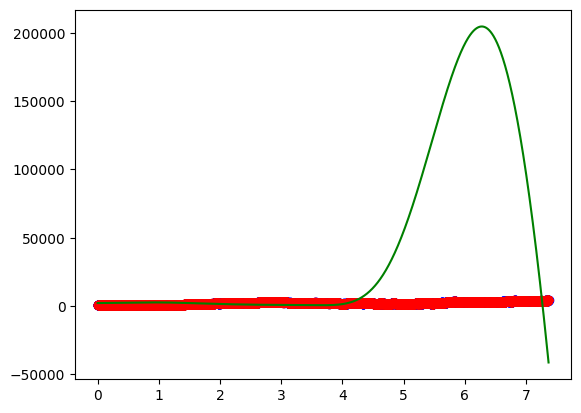

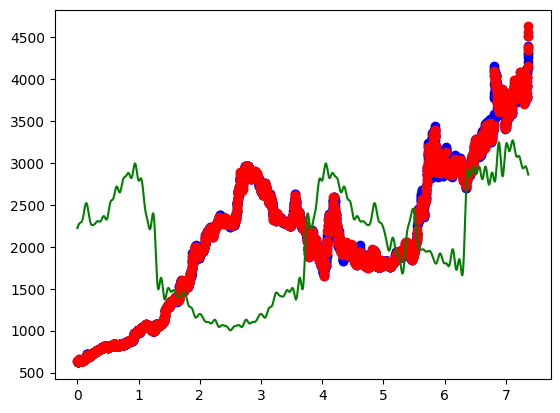

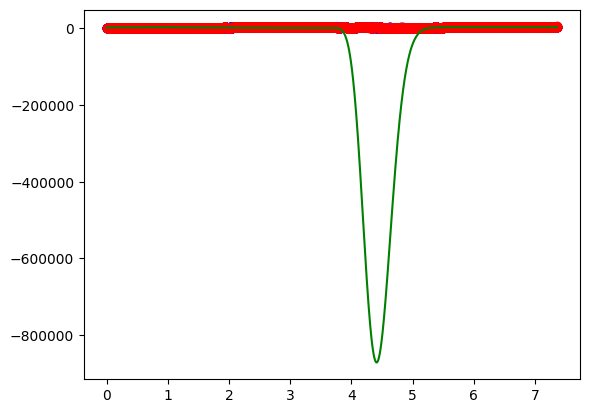

In [ ]:
K = 100

Phi_expo = expo_carac(X_train_pca, K)
Phi_cos = cos_carac(X_train_pca, K)
Phi_sigmo = sigmo_carac(X_train_pca, K)

# inferencia usando max vero

theta_expo = inferencia_max_vero_carac(Phi_expo, y_train)
theta_cos = inferencia_max_vero_carac(Phi_cos, y_train)
theta_sigmo = inferencia_max_vero_carac(Phi_sigmo, y_train)


# predicción sobre todos los datos 
Phi_test_expo = expo_carac(x, K) # características todos los datos
Phi_test_cos = cos_carac(x, K) # características todos los datos
Phi_test_sigmo = sigmo_carac(x, K) # características todos los datos

y_predexpo = Phi_test_expo @ theta_expo
y_predcos = Phi_test_cos @ theta_cos
y_predsigmo = Phi_test_sigmo @ theta_sigmo

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predsigmo, color='green', label='Predicción')
plt.show()

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predcos, color='green', label='Predicción')

plt.show()

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predexpo, color='green', label='Predicción')
plt.show()


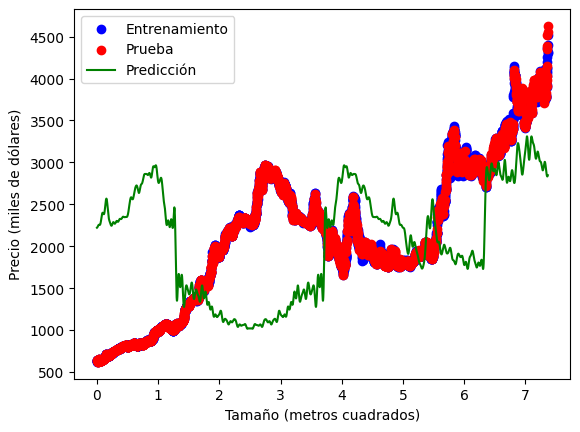

In [ ]:
# Aplicar PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)

K = 200

Phi_cos = cos_carac(X_train_pca, K)

# inferencia usando max vero

theta_cos = inferencia_max_vero_carac(Phi_cos, y_train)


# predicción sobre todos los datos 
Phi_test_cos = cos_carac(x, K) # características todos los datos

y_pred = Phi_test_cos @ theta_cos

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_pred, color='green', label='Predicción')
plt.xlabel('Tamaño (metros cuadrados)')
plt.ylabel('Precio (miles de dólares)')
plt.legend()
plt.show()
